In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [2]:
# Importing modules
import pandas as pd

# Read data 
df=pd.read_excel("data_sdgs and non_final.xlsx")
# Print head
df.head(1)

,Company Name,Long_description,Type
0,Affect Therapeutics,Affect is using digital technology to deliver ...,SDGs


In [3]:
train, test= train_test_split(df,test_size=0.1,random_state=0)

In [4]:
# Load the regular expression library
import re
# Remove punctuation
train['Long_description_processed'] = train['Long_description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the text to lowercase
train['Long_description_processed'] = train['Long_description_processed'].map(lambda x: x.lower())
#Print the first rows of descriptions
train['Long_description_processed'].head()

C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1949    curiositystream is a global factual streaming ...
1583    factorial is a human resources software platfo...
2060    apptio is the leading provider of cloud-based ...
342     skout cybersecurity is a channel-only provider...
1833    grip is an investment platform that allows ret...
Name: Long_description_processed, dtype: object

In [5]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = train.Long_description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['curiositystream', 'is', 'global', 'factual', 'streaming', 'services', 'and', 'media', 'companies', 'our', 'documentary', 'series', 'and', 'features', 'cover', 'every', 'topic', 'from', 'space', 'exploration', 'to', 'adventure', 'to', 'the', 'secret', 'life', 'of', 'pets', 'empowering', 'viewers']


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# same process, but faster
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['curiositystream', 'global', 'factual', 'streaming', 'service', 'medium', 'company', 'documentary', 'series', 'feature', 'cover', 'topic', 'space', 'exploration', 'adventure', 'secret', 'life', 'pet', 'empower', 'viewer', 'age', 'fuel', 'passion', 'explore', 'new', 'one', 'thousand', 'title', 'many', 'ultra', 'hd', 'include', 'exclusive', 'original', 'curiositystream', 'feature', 'stunning', 'visual', 'unrivaled', 'storytelling', 'demystify', 'science', 'nature', 'history', 'technology', 'society', 'lifestyle', 'curiositystream', 'programming', 'available', 'worldwide', 'watch', 'tv', 'desktop', 'mobile', 'tablet', 'find', 'roku', 'apple', 'tv', 'channel', 'apple', 'tv', 'xbox', 'amazon', 'fire', 'tv', 'google', 'chromecast', 'io', 'android', 'well', 'amazon', 'prime', 'video', 'channel', 'youtube', 'tv', 'sling', 'tv', 'dish', 'comcast', 'xfinity', 'demand', 'cox', 'communication', 'altice', 'usa', 'suddenlink', 'mobile', 'frndly', 'tv', 'vidgo', 'sony', 'samsung', 'vizio', 'smart',

In [9]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized

In [10]:
'''
Checking dictionary created
'''
count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 8:
        break

0 adventure
1 age
2 altice
3 amazon
4 android
5 apple
6 available
7 channel
8 chromecast


In [11]:
#filter extremes
id2word.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [12]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [13]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=2, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True
                                       )

In [14]:
from pprint import pprint
# Print the Keyword in the 2 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"system" + 0.007*"new" + 0.007*"market" + 0.007*"development" + '
  '0.007*"social" + 0.007*"industry" + 0.007*"energy" + 0.007*"community" + '
  '0.007*"design" + 0.006*"drive"'),
 (1,
  '0.012*"user" + 0.010*"health" + 0.009*"online" + 0.009*"access" + '
  '0.008*"software" + 0.008*"payment" + 0.007*"care" + 0.007*"app" + '
  '0.007*"mobile" + 0.006*"manage"')]


In [15]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2567488318702852


In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.481021178074939


In [17]:
#convert gensim log_perplexity to the perlexity value from scikitlearn, to make them comparable !!
np.exp(-1.*lda_model.log_perplexity(corpus))

652.637085774719

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values=[]
    model_list=[]
    for num_topics in range (start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, random_state=100, chunksize=200, 
                                      passes=10, per_word_topics=True, id2word=id2word, workers=3)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
        

In [18]:
model_list, coherence_values=compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
                                                      start=2, limit=4,step=1)

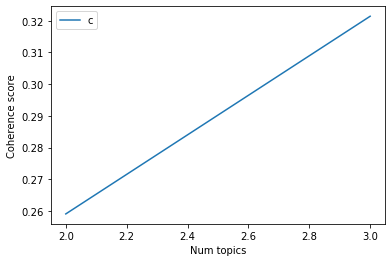

In [19]:
#show graph
from matplotlib import pyplot as plt
limit=4; start=2; step=1;
x=range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [20]:
#print the coherence score
for m, cv in zip(x, coherence_values):
    print("Num topics=", m, "has coherence value of", round(cv,4))

Num topics= 2 has coherence value of 0.2591
Num topics= 3 has coherence value of 0.3214


# Hyperparameter Tuning¶
 Model hyperparameters:

Number of Topics (K)

Dirichlet hyperparameter alpha: Document-Topic Density

Dirichlet hyperparameter eta: Word-Topic Density

One parameter at a time by keeping others constant and run them oveR validation corpus sets. Use C_v as our choice of metric for performance comparison

In [21]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [22]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in eta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Eta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results2ETA.csv', index=False)
    pbar.close()


100%|██████████| 540/540 [2:12:08<00:00, 14.68s/it]  


In [18]:
#final LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.91)

In [19]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42117224966847155


In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.612508120602159


In [21]:
#convert gensim log_perplexity to the perlexity value from scikitlearn, to make them comparable 
np.exp(-1.*lda_model.log_perplexity(corpus))

744.3475928531425

In [38]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [39]:
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)

C:\Users\daian\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [40]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.080285 -0.119301       1        1  14.915718
6     -0.136679 -0.072004       2        1  14.718279
8     -0.052474 -0.026214       3        1  11.752526
4      0.082415 -0.014311       4        1  11.115124
7     -0.044272  0.078061       5        1  10.196761
0      0.044421  0.029921       6        1   9.641296
2      0.005702  0.048680       7        1   9.513987
3      0.023310  0.061236       8        1   9.465569
5     -0.002708  0.013932       9        1   8.680741, topic_info=           Term        Freq       Total Category  logprob  loglift
163      health  225.000000  225.000000  Default  30.0000  30.0000
252      energy  114.000000  114.000000  Default  29.0000  29.0000
142     payment  153.000000  153.000000  Default  28.0000  28.0000
164  healthcare  129.000000  129.000000  Default  27.0000  27.0000
136        home  131.000000  131.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
51         fast   16.604667  108.994682   Topic9  -5.3728   0.5624
189        also   18.193311  163.291278   Topic9  -5.2814   0.2496
232      access   18.293293  236.402256   Topic9  -5.2759  -0.1149
17          new   17.463147  196.970754   Topic9  -5.3224   0.0211
220       first   16.294768  147.947473   Topic9  -5.3916   0.2381

[454 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
318       1  0.045122  academic
318       2  0.045122  academic
318       3  0.045122  academic
318       4  0.180489  academic
318       5  0.360978  academic
...     ...       ...       ...
414       5  0.050899  workflow
414       6  0.025450  workflow
414       7  0.050899  workflow
414       8  0.025450  workflow
414       9  0.025450  workflow

[3213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 9, 5, 8, 1, 3, 4, 6])

In [42]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"social" + 0.018*"food" + 0.016*"farmer" + 0.013*"produce" + 0.011*"impact" + 0.008*"market" + 0.008*"sector" + 0.008*"mission" + 0.008*"community" + 0.008*"value"
Topic: 1 
Words: 0.023*"payment" + 0.017*"capital" + 0.015*"online" + 0.015*"venture" + 0.014*"credit" + 0.014*"consumer" + 0.011*"app" + 0.010*"investor" + 0.010*"investment" + 0.010*"money"
Topic: 2 
Words: 0.026*"healthcare" + 0.017*"life" + 0.016*"patient" + 0.013*"family" + 0.013*"care" + 0.011*"community" + 0.008*"find" + 0.008*"event" + 0.008*"need" + 0.007*"share"
Topic: 3 
Words: 0.027*"energy" + 0.021*"power" + 0.012*"design" + 0.012*"system" + 0.012*"school" + 0.011*"project" + 0.010*"solar" + 0.009*"vehicle" + 0.009*"market" + 0.009*"electric"
Topic: 4 
Words: 0.019*"finance" + 0.019*"insurance" + 0.018*"bank" + 0.017*"india" + 0.017*"small" + 0.013*"loan" + 0.011*"online" + 0.010*"student" + 0.010*"new" + 0.010*"banking"
Topic: 5 
Words: 0.028*"home" + 0.021*"network" + 0.015*"delivery" + 

In [22]:
data_test=test.Long_description.values.tolist()

In [23]:
# Load the regular expression library
import re
# Remove punctuation
test['Long_description_processed'] = test['Long_description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the descriptions to lowercase
test['Long_description_processed'] = test['Long_description_processed'].map(lambda x: x.lower())
# Print out the first rows of descriptions
test['Long_description_processed'].head(12)

C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


810     metaweb technologies was spun out of applied m...
1785    mark43 creates the next generation of law enfo...
2108    instructure is a technology company that is fo...
2099    trulioo operates a digital identity network th...
1638    somatus is a healthcare company that partners ...
512     young 1ove is a grassroots youth-led evidence-...
913     bunker is the leading insurtech providing inst...
2063    smartrecruiters is an end-to-end recruiting pl...
474     inspired by the noble cause of serving indian ...
686     the cargox platform for blockchain document tr...
1379    bluecore is a multi-channel marketing platform...
1354    bloom & wild a letterbox flower delivery compa...
Name: Long_description_processed, dtype: object

In [24]:
data = test.Long_description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['metaweb', 'technologies', 'was', 'spun', 'out', 'of', 'applied', 'minds', 'in', 'july', 'to', 'build', 'better', 'infrastructure', 'for', 'the', 'web', 'after', 'several', 'years', 'of', 'development', 'we', 'recently', 'launched', 'our', 'first', 'product', 'freebase', 'an']


In [25]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[['metaweb', 'technology', 'spin', 'applied', 'mind', 'july', 'build', 'well', 'infrastructure', 'web', 'several', 'year', 'development', 'recently', 'launch', 'first', 'product', 'freebase', 'open', 'share', 'database', 'world', 'information', 'freebase', 'open', 'database', 'world', 'information', 'build', 'community', 'community', 'free', 'query', 'contribute', 'build', 'application', 'top', 'integrate', 'website'], ['mark', 'create', 'next_generation', 'law', 'enforcement', 'software', 'allow', 'police', 'effortlessly', 'collect', 'manage', 'analyze', 'share', 'information', 'mission', 'empower', 'community', 'government', 'new', 'technology', 'improve', 'safety', 'quality', 'life', 'intuitive', 'software', 'deliver', 'cloud', 'first', 'technology', 'datum', 'drive', 'insight', 'public', 'safety', 'company', 'found', 'base', 'new_york', 'city']]


In [26]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized

In [27]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2])

[[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1)], [(3, 1), (7, 1), (10, 1), (22, 1), (24, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 2)]]


In [49]:
texts[:5]

[['metaweb',
  'technology',
  'spin',
  'applied',
  'mind',
  'july',
  'build',
  'well',
  'infrastructure',
  'web',
  'several',
  'year',
  'development',
  'recently',
  'launch',
  'first',
  'product',
  'freebase',
  'open',
  'share',
  'database',
  'world',
  'information',
  'freebase',
  'open',
  'database',
  'world',
  'information',
  'build',
  'community',
  'community',
  'free',
  'query',
  'contribute',
  'build',
  'application',
  'top',
  'integrate',
  'website'],
 ['mark',
  'create',
  'next_generation',
  'law',
  'enforcement',
  'software',
  'allow',
  'police',
  'effortlessly',
  'collect',
  'manage',
  'analyze',
  'share',
  'information',
  'mission',
  'empower',
  'community',
  'government',
  'new',
  'technology',
  'improve',
  'safety',
  'quality',
  'life',
  'intuitive',
  'software',
  'deliver',
  'cloud',
  'first',
  'technology',
  'datum',
  'drive',
  'insight',
  'public',
  'safety',
  'company',
  'found',
  'base',
  'new_y

In [50]:
num=0
unseen_document = corpus[num]
print(unseen_document)

[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1)]


In [51]:
#bow_vector = dictionary.doc2bow((unseen_document))

for index, score in sorted(lda_model[unseen_document], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 8)))

Score: 0.35520750284194946	 Topic: 0.021*"ai" + 0.020*"brand" + 0.014*"sale" + 0.013*"insight" + 0.013*"analytic" + 0.012*"marketing" + 0.011*"drive" + 0.011*"content"
Score: 0.25959569215774536	 Topic: 0.026*"healthcare" + 0.017*"life" + 0.016*"patient" + 0.013*"family" + 0.013*"care" + 0.011*"community" + 0.008*"find" + 0.008*"event"
Score: 0.08304018527269363	 Topic: 0.026*"software" + 0.025*"user" + 0.021*"security" + 0.019*"application" + 0.015*"cloud" + 0.012*"manage" + 0.012*"secure" + 0.011*"automate"
Score: 0.0782923772931099	 Topic: 0.028*"home" + 0.021*"network" + 0.015*"delivery" + 0.011*"client" + 0.011*"space" + 0.011*"infrastructure" + 0.010*"internet" + 0.009*"system"
Score: 0.050623465329408646	 Topic: 0.023*"payment" + 0.017*"capital" + 0.015*"online" + 0.015*"venture" + 0.014*"credit" + 0.014*"consumer" + 0.011*"app" + 0.010*"investor"
Score: 0.049751222133636475	 Topic: 0.027*"energy" + 0.021*"power" + 0.012*"design" + 0.012*"system" + 0.012*"school" + 0.011*"projec

In [52]:
num=5
unseen_document = corpus[num]
print(unseen_document)

[(10, 1), (30, 1), (33, 2), (40, 2), (46, 1), (51, 1), (54, 1), (63, 1), (76, 1), (81, 1), (103, 1), (115, 1), (124, 1), (141, 1), (160, 3), (165, 1), (177, 1), (186, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1), (221, 2), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 2), (239, 1), (240, 1), (241, 1), (242, 4), (243, 2), (244, 1), (245, 1), (246, 1), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 2), (255, 2), (256, 1), (257, 1), (258, 1), (259, 1), (260, 2), (261, 5), (262, 3), (263, 2)]


In [53]:
for index, score in sorted(lda_model[unseen_document], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 8)))

Score: 0.2907371520996094	 Topic: 0.026*"software" + 0.025*"user" + 0.021*"security" + 0.019*"application" + 0.015*"cloud" + 0.012*"manage" + 0.012*"secure" + 0.011*"automate"
Score: 0.1857650727033615	 Topic: 0.027*"energy" + 0.021*"power" + 0.012*"design" + 0.012*"system" + 0.012*"school" + 0.011*"project" + 0.010*"solar" + 0.009*"vehicle"
Score: 0.1845799684524536	 Topic: 0.023*"payment" + 0.017*"capital" + 0.015*"online" + 0.015*"venture" + 0.014*"credit" + 0.014*"consumer" + 0.011*"app" + 0.010*"investor"
Score: 0.08347582817077637	 Topic: 0.019*"finance" + 0.019*"insurance" + 0.018*"bank" + 0.017*"india" + 0.017*"small" + 0.013*"loan" + 0.011*"online" + 0.010*"student"
Score: 0.07677315920591354	 Topic: 0.023*"social" + 0.018*"food" + 0.016*"farmer" + 0.013*"produce" + 0.011*"impact" + 0.008*"market" + 0.008*"sector" + 0.008*"mission"
Score: 0.07653695344924927	 Topic: 0.021*"ai" + 0.020*"brand" + 0.014*"sale" + 0.013*"insight" + 0.013*"analytic" + 0.012*"marketing" + 0.011*"driv

In [30]:
data_test=test.Long_description.values.tolist()

In [31]:
# Load the regular expression library
import re
# Remove punctuation
test['Long_description_processed'] = test['Long_description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the descriptions to lowercase
test['Long_description_processed'] = test['Long_description_processed'].map(lambda x: x.lower())
# Print out the first rows of descriptions
test['Long_description_processed'].head(12)

C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


810     metaweb technologies was spun out of applied m...
1785    mark43 creates the next generation of law enfo...
2108    instructure is a technology company that is fo...
2099    trulioo operates a digital identity network th...
1638    somatus is a healthcare company that partners ...
512     young 1ove is a grassroots youth-led evidence-...
913     bunker is the leading insurtech providing inst...
2063    smartrecruiters is an end-to-end recruiting pl...
474     inspired by the noble cause of serving indian ...
686     the cargox platform for blockchain document tr...
1379    bluecore is a multi-channel marketing platform...
1354    bloom & wild a letterbox flower delivery compa...
Name: Long_description_processed, dtype: object

In [32]:
data = test.Long_description_processed.values.tolist()
data_words = list(sent_to_words(data))

In [33]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[['metaweb', 'technology', 'spin', 'applied', 'mind', 'july', 'build', 'well', 'infrastructure', 'web', 'several', 'year', 'development', 'recently', 'launch', 'first', 'product', 'freebase', 'open', 'share', 'database', 'world', 'information', 'freebase', 'open', 'database', 'world', 'information', 'build', 'community', 'community', 'free', 'query', 'contribute', 'build', 'application', 'top', 'integrate', 'website'], ['mark', 'create', 'next_generation', 'law', 'enforcement', 'software', 'allow', 'police', 'effortlessly', 'collect', 'manage', 'analyze', 'share', 'information', 'mission', 'empower', 'community', 'government', 'new', 'technology', 'improve', 'safety', 'quality', 'life', 'intuitive', 'software', 'deliver', 'cloud', 'first', 'technology', 'datum', 'drive', 'insight', 'public', 'safety', 'company', 'found', 'base', 'new_york', 'city']]


In [34]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized

In [41]:
# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts]
# View
print(corpus1[:2])

[[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1)], [(3, 1), (7, 1), (10, 1), (22, 1), (24, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 2)]]
